# Head Estimation, Pose Conversion & Visualization

## 1. Load and Process Keypoints JSON

In [114]:
import json

# Load person_keypoints_train2017.json and extract poses which have all of their body keypoints
'''
"keypoints": [
                        "nose",
                        "left_eye",
                        "right_eye",
                        "left_ear",
                        "right_ear",
                        
                        "left_shoulder",
                        "right_shoulder",
                        "left_elbow",
                        "right_elbow",
                        "left_wrist",
                        "right_wrist",

                        "left_hip",
                        "right_hip",
                        "left_knee",
                        "right_knee",
                        "left_ankle",
                        "right_ankle"
                    ],
'''

def extract_poses(file_path, scale=2):
    with open(file_path, 'r') as f:
        data = json.load(f)

    poses_list = []

    for annotation in data['annotations']:
        visibility = annotation['keypoints'][2::3]

        if 0 not in visibility[:5]:
            keypoints_x = annotation['keypoints'][0::3]
            keypoints_y = annotation['keypoints'][1::3]

            max_x = max(keypoints_x)
            min_x = min(keypoints_x)
            max_y = max(keypoints_y)
            min_y = min(keypoints_y)

            height = max_y - min_y
            width = max_x - min_x

            if height > width:
                keypoints_x = [((x - min_x) / height - 0.5) * scale for x in keypoints_x]
                keypoints_y = [((y - min_y) / height - 0.5) * scale for y in keypoints_y]
            else:
                keypoints_x = [((x - min_x) / width - 0.5) * scale for x in keypoints_x]
                keypoints_y = [((y - min_y) / width - 0.5) * scale for y in keypoints_y]

            poses_list.append((keypoints_x[5:] + keypoints_y[5:], 
                                   keypoints_x[:5] + keypoints_y[:5]))

    return poses_list

# File path to the JSON file
file_path = 'person_keypoints_train2017.json'

# Extract keypoints
extracted_poses = extract_poses(file_path)

# Print the result
result_len = len(extracted_poses)
print(extracted_poses[:5])
print(f"Number of extracted poses: {result_len}")

split = 0.8

# Save the result
with open("train.json", "w") as train:
    json.dump(extracted_poses[:int(result_len * split)], train)

with open("test.json", "w") as test:
    json.dump(extracted_poses[int(result_len * split):], test)

[([0.16450216450216448, -0.4415584415584416, 0.303030303030303, -0.5930735930735931, -1.0, -0.5411255411255411, 0.1212121212121211, -0.2987012987012987, 0.48051948051948057, -0.5238095238095238, 0.48051948051948057, -0.5281385281385281, -0.37662337662337664, -0.35930735930735935, -0.1515151515151515, -0.11688311688311692, -1.0, -0.07359307359307354, 0.2554112554112553, 0.2683982683982684, 0.48484848484848486, 0.48484848484848486, 0.9610389610389611, 1.0], [-0.10822510822510822, -0.04761904761904767, -0.18614718614718617, 0.017316017316017396, -0.2727272727272727, -0.6580086580086579, -0.7012987012987013, -0.7012987012987013, -0.6320346320346321, -0.6190476190476191]), ([0.9293598233995586, 0.7792494481236203, 1.0, 0.739514348785872, 0.9426048565121412, 0.7924944812362031, 0.9293598233995586, 0.7880794701986755, -1.0, -1.0, -1.0, -1.0, -0.015452538631346546, -0.01103752759381893, 0.06843267108167761, 0.04635761589403975, 0.050772626931567366, 0.04635761589403975, 0.14348785871964687, 0.

## 2. Load Libraries

In [115]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset

print(f"MPS Support: {torch.backends.mps.is_built()}")
print(f"MPS Availability: {torch.backends.mps.is_available()}")

MPS Support: True
MPS Availability: True


In [116]:
device = None

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f'Device: {device}')

Device: mps


## 3. Dataloader and Model Definition

### Dataloader

In [117]:
split = 0.8

class TrainDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        train_path = data_dir + "/train.json"

        with open(train_path, 'r') as f:
            data = json.load(f)
            data_len = len(data)
            self.data = data[:int(data_len * split)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data[index][0]), torch.tensor(self.data[index][1])


class ValDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        train_path = data_dir + "/train.json"

        with open(train_path, 'r') as f:
            data = json.load(f)
            data_len = len(data)
            self.data = data[int(data_len * split):]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data[index][0]), torch.tensor(self.data[index][1])
    
    
class TestDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        test_path = data_dir + "/test.json"

        with open(test_path, 'r') as f:
            self.data = json.load(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data[index][0]), torch.tensor(self.data[index][1])

In [118]:
import json

train_dataset = TrainDataset(data_dir='.')
val_dataset = ValDataset(data_dir='.')
test_dataset = TestDataset(data_dir='.')

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

15176
3794
4743


### Model

In [146]:
# Define the model
class HeadEstimator(nn.Module):
    def __init__(self):
        super(HeadEstimator, self).__init__()
        self.fc1 = nn.Linear(24, 64)  # 12 MPII/COCO keypoints * 2 (x, y)
        self.fc2 = nn.Linear(64, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 10)  # 17 COCO keypoints * 2 (x, y)
        self.dropout = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(512)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight.data)
                nn.init.zeros_(m.bias.data)
                

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        out = self.fc4(x)

        return out

### Train and Val Function

In [154]:
def train_model(trainloader, model, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    for batch, (inputs, targets) in tqdm(enumerate(trainloader), total=len(trainloader)):

        inputs = inputs.to(device)
        targets = targets.to(device)
        #criterion = criterion.to(device)

        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, targets)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.cpu().item()

    return total_loss / (batch + 1)

In [155]:
def val_model(valloader, model, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch, (inputs, targets) in tqdm(enumerate(valloader), total = len(valloader)):

            inputs = inputs.to(device)
            targets = targets.to(device)
            #criterion = criterion.to(device)

            preds = model(inputs)
            loss = criterion(preds, targets)
            
            total_loss += loss.cpu().item()

    return total_loss/(batch+1)

## 4. Training Model

In [156]:
batch_size = 128
learning_rate = 1e-4
epochs = 20

trainLoader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valLoader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

model = HeadEstimator()
model = model.to(device)

def loss(preds, targets):
    mse = torch.mean((preds - targets) ** 2)
    average_x = torch.mean((torch.mean(preds[:, 1:5], dim=1) - preds[:, 0]) ** 2)
    average_y = torch.mean((torch.mean(preds[:, 6:10], dim=1) - preds[:, 5]) ** 2)

    return mse + average_x + average_y

#criterion = nn.MSELoss()
criterion = loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.5)

history = {'train_loss':[], 'val_loss':[]}

print(model)

HeadEstimator(
  (fc1): Linear(in_features=24, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [157]:
print("Training...")

for epoch in range(epochs):
    train_loss = train_model(trainLoader, model, criterion, optimizer, scheduler, device)
    val_loss = val_model(valLoader, model, criterion, device)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    if (epoch+1) % 5 == 0 or epoch == epochs-1:
        print("Saving checkpoint...")
        torch.save(model.state_dict(), f'./model.pth')

print('Finished Training')

Training...


100%|██████████| 30/30 [00:00<00:00, 37.88it/s] 


Epoch 1/20, Train Loss: 1.6683, Val Loss: 0.2577


100%|██████████| 30/30 [00:00<00:00, 139.17it/s]


Epoch 2/20, Train Loss: 0.8325, Val Loss: 0.2005


100%|██████████| 30/30 [00:00<00:00, 142.71it/s]


Epoch 3/20, Train Loss: 0.6310, Val Loss: 0.1538


100%|██████████| 30/30 [00:00<00:00, 140.42it/s]


Epoch 4/20, Train Loss: 0.5113, Val Loss: 0.1456


100%|██████████| 30/30 [00:00<00:00, 142.49it/s]


Epoch 5/20, Train Loss: 0.4440, Val Loss: 0.1163
Saving checkpoint...


100%|██████████| 30/30 [00:00<00:00, 138.94it/s]


Epoch 6/20, Train Loss: 0.3850, Val Loss: 0.1182


100%|██████████| 30/30 [00:00<00:00, 140.15it/s]


Epoch 7/20, Train Loss: 0.3413, Val Loss: 0.1033


100%|██████████| 30/30 [00:00<00:00, 142.95it/s]


Epoch 8/20, Train Loss: 0.3057, Val Loss: 0.0983


100%|██████████| 30/30 [00:00<00:00, 140.94it/s]


Epoch 9/20, Train Loss: 0.2772, Val Loss: 0.0915


100%|██████████| 30/30 [00:00<00:00, 141.67it/s]


Epoch 10/20, Train Loss: 0.2591, Val Loss: 0.0865
Saving checkpoint...


100%|██████████| 30/30 [00:00<00:00, 141.91it/s]


Epoch 11/20, Train Loss: 0.2405, Val Loss: 0.0896


100%|██████████| 30/30 [00:00<00:00, 137.19it/s]


Epoch 12/20, Train Loss: 0.2301, Val Loss: 0.0824


100%|██████████| 30/30 [00:00<00:00, 139.53it/s]


Epoch 13/20, Train Loss: 0.2173, Val Loss: 0.0807


100%|██████████| 30/30 [00:00<00:00, 141.19it/s]


Epoch 14/20, Train Loss: 0.2084, Val Loss: 0.0800


100%|██████████| 30/30 [00:00<00:00, 138.83it/s]


Epoch 15/20, Train Loss: 0.1970, Val Loss: 0.0757
Saving checkpoint...


100%|██████████| 30/30 [00:00<00:00, 144.45it/s]


Epoch 16/20, Train Loss: 0.1888, Val Loss: 0.0769


100%|██████████| 30/30 [00:00<00:00, 145.07it/s]


Epoch 17/20, Train Loss: 0.1778, Val Loss: 0.0762


100%|██████████| 30/30 [00:00<00:00, 145.45it/s]


Epoch 18/20, Train Loss: 0.1734, Val Loss: 0.0765


100%|██████████| 30/30 [00:00<00:00, 144.31it/s]


Epoch 19/20, Train Loss: 0.1679, Val Loss: 0.0714


100%|██████████| 30/30 [00:00<00:00, 136.21it/s]

Epoch 20/20, Train Loss: 0.1634, Val Loss: 0.0721
Saving checkpoint...
Finished Training


<function matplotlib.pyplot.show(close=None, block=None)>

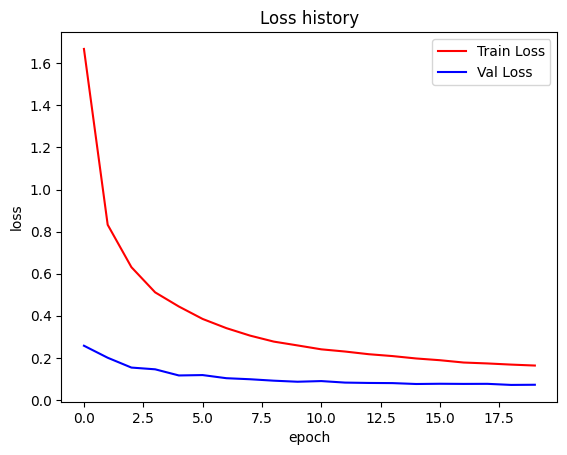

In [158]:
plt.plot(range(epochs), history['train_loss'], label='Train Loss', color='red')
plt.plot(range(epochs), history['val_loss'], label='Val Loss', color='blue')

plt.title('Loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show

## 5. Test Model

In [159]:
def test_model(testloader, model, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch, (inputs, targets) in tqdm(enumerate(testloader), total = len(testloader)):

            inputs = inputs.to(device)
            targets = targets.to(device)

            preds = model(inputs)
            loss = criterion(preds, targets)
            
            total_loss += loss.cpu().item()

    return total_loss/(batch+1)

In [160]:
testLoader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

print("Testing...")
test_loss = test_model(testLoader, model, criterion, device)

print(f"Test Loss: {test_loss:.4f}")

Testing...


100%|██████████| 38/38 [00:00<00:00, 43.55it/s] 

Test Loss: 0.0816


## 6. Inference and Visualization Functions

In [161]:
def inference(model, device, x):
    model.eval()
    x = x.to(device)

    with torch.no_grad():
        pred = model(x)
        
    return pred[:10]

In [162]:
def normalize_pose(pose, scale=2):
    
    keypoints_x = [point[0] for point in pose]
    keypoints_y = [point[1] for point in pose]

    min_x = min(keypoints_x)
    max_x = max(keypoints_x)
    min_y = min(keypoints_y)
    max_y = max(keypoints_y)
    
    height = max_y - min_y
    width = max_x - min_x

    if height > width:
        keypoints_x = [((x - min_x) / height - 0.5) * scale for x in keypoints_x]
        keypoints_y = [((y - min_y) / height - 0.5) * scale for y in keypoints_y]
        original_scale = height
    else:
        keypoints_x = [((x - min_x) / width - 0.5) * scale for x in keypoints_x]
        keypoints_y = [((y - min_y) / width - 0.5) * scale for y in keypoints_y]
        original_scale = width

    
    print('keypoints_x = "', keypoints_x, '"')
    print('keypoints_y = "', keypoints_y, '"\n')

    pose = [(x, y) for x, y in zip(keypoints_x, keypoints_y)]

    return pose, min_x, min_y, original_scale, original_scale

def denormalize_pose(pose, min_x, min_y, width, height, scale=2):
    pose = [((x / scale + 0.5) * width + min_x, (y / scale + 0.5) * height + min_y) for (x, y) in pose]

    return pose

def resize_pose(pose, resize_width=200, resize_height=200, padding=10, scale=2):
    pose, _, _, _, _ = normalize_pose(pose, scale)
    pose = [((x / scale + 0.5) * resize_width + padding, (y / scale + 0.5) * resize_height + padding) for (x, y) in pose]

    return pose

In [163]:
'''
coco (original):
0 : nose
1 2 : eyes
3 4 : ears
5 7 9 : left arm
6 8 10: right arm
11 13 15: left leg
12 14 16: right leg

mpii (ours):
13 14 15 : left arm
12 11 10 : right arm
3 4 5 : left leg
2 1 0 : right leg
7 : neck
9 8 : head

coco (ours):
0 : nose
1 : neck
2 3 4 : right arm
5 6 7 : left arm
8 9 10 : right leg
11 12 13 : left leg
14 15 : eyes
16 17 : ears
'''

def convert_pose(model, device, pose):
    # re-order keypoints to match neural network input
    pose, min_x, min_y, width, height = normalize_pose(pose)

    reordered_pose = [pose[13], pose[12], pose[14], pose[11], pose[15], pose[10], pose[3], pose[2], pose[4], pose[1], pose[5], pose[0]]

    reordered_x = [point[0] for point in reordered_pose]
    reordered_y = [point[1] for point in reordered_pose]

    input_pose = torch.tensor([reordered_x + reordered_y])

    # head inference
    head = inference(model, device, input_pose)[0].cpu().tolist()
    head_points = [(x, y) for x, y in zip(head[:5], head[5:])]

    # insert head keypoints to the pose
    reordered_pose = [head_points[0], pose[7], pose[12], pose[11], pose[10], pose[13], pose[14], pose[15], pose[2], pose[1], pose[0], pose[3], pose[4], pose[5],
                      head_points[1], head_points[2], head_points[3], head_points[4]]
    
    reordered_pose = denormalize_pose(reordered_pose, min_x, min_y, width, height)

    return reordered_pose

In [164]:
import cv2
import matplotlib.pyplot as plt


mpii_link_pairs = [[0, 1], [1, 2], [2, 6], 
              [3, 6], [3, 4], [4, 5], 
              [6, 7], [7,12], [11, 12], 
              [10, 11], [7, 13], [13, 14],
              [14, 15],[7, 8],[8, 9]]

mpii_link_color = [(0, 0, 255), (0, 0, 255), (0, 0, 255),
              (0, 255, 0), (0, 255, 0), (0, 255, 0),
              (0, 255, 255), (0, 0, 255), (0, 0, 255),
              (0, 0, 255), (0, 255, 0), (0, 255, 0),
              (0, 255, 0), (0, 255, 255), (0, 255, 255)]

mpii_point_color = [(255,0,0),(0,255,0),(0,0,255), 
               (128,0,0), (0,128,0), (0,0,128),
               (255, 255, 0),(0,255,255),(255, 0, 255),
               (128,128,0),(0, 128, 128),(128,0,128),
               (128,255,0),(128,128,128),(255,128,0),
               (255,0,128),(255,255,255)]


coco_link_pairs = [[0, 1], [1, 2], [2, 3], 
              [3, 4], [1, 5], [5, 6], 
              [6, 7], [1, 8], [8, 9], 
              [9, 10], [1, 11], [11, 12],
              [12, 13],[0, 14],[14, 16], [0, 15], [15, 17]]

coco_link_color = [(0, 0, 255), (0, 0, 255), (0, 0, 255),
              (0, 255, 0), (0, 255, 0), (0, 255, 0),
              (0, 255, 255), (0, 0, 255), (0, 0, 255),
              (0, 0, 255), (0, 255, 0), (0, 255, 0),
              (0, 255, 0), (0, 255, 255), (0, 255, 255), (128, 128, 0), (128, 0, 128)]

coco_point_color = [(255,0,0),(0,255,0),(0,0,255), 
               (128,0,0), (0,128,0), (0,0,128),
               (255, 255, 0),(0,255,255),(255, 0, 255),
               (128,128,0),(0, 128, 128),(128,0,128),
               (128,255,0),(128,128,128),(255,128,0),
               (255,0,128),(255,255,255), (128, 128, 0), (128, 0, 128)]

'''
mpii (ours):
2 1 0 : right leg
3 4 5 : left leg
12 11 10 : right arm
13 14 15 : left arm
7 : neck
9 8 : head

coco (ours):
0 : nose
1 : neck
2 3 4 : right arm
5 6 7 : left arm
8 9 10 : right leg
11 12 13 : left leg
14 15 : eyes
16 17 : ears
'''

def vis_pose(image_path, pose, link_pairs, link_color, point_color):
    image = cv2.imread(image_path)

    pose = [(int(x), int(y)) for (x, y) in pose]

    for idx, pair in enumerate(link_pairs):
        if pose[pair[0]] != (0, 0) and pose[pair[1]] != (0, 0):
            cv2.line(image, pose[pair[0]], pose[pair[1]], link_color[idx], 2)

    for idx, point in enumerate(pose):
        if point != (0, 0):
            cv2.putText(image, str(idx), point, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            cv2.circle(image, point, 5, point_color[idx], thickness=-1)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


def vis_pose_mpii(image_path, pose):
    vis_pose(image_path, pose, mpii_link_pairs, mpii_link_color, mpii_point_color)


def vis_pose_coco(image_path, pose):
    vis_pose(image_path, pose, coco_link_pairs, coco_link_color, coco_point_color)

In [165]:
import os

def vis_data(model, device, data, image_dir_path='./affordance_data/data'):
    data = data.split(' ')
    image_path = os.path.join(image_dir_path, data[0])
    pose_data = data[1:-1]
    pose_data = [eval(x) for x in pose_data]

    pose = []
    for i in range(0, len(pose_data), 2):
        pose.append((pose_data[i], pose_data[i+1]))

    vis_pose_mpii(image_path, pose)

    pose = convert_pose(model, device, pose)
    vis_pose_coco(image_path, pose)
    vis_pose_coco(image_path, resize_pose(pose))

## 7. Pose Visualization

In [166]:
# Load Checkpoint
model = HeadEstimator()
model.load_state_dict(torch.load(f'./model.pth'))
model = model.to(device)

In [ ]:
train_data_path = './affordance_data/trainlist.txt'
train_data = []
with open(train_data_path, 'r') as f:
    train_data = list(f.readlines())

for data in train_data[1000:]:
    vis_data(model, device, data)
    input()